Current: (52.13349293552722, 4.660748132913985), Parent: (np.float64(52.13348496893562), np.float64(4.660748132913985))
Current: (52.13353486901042, 4.660677751033938), Parent: (np.float64(52.13353886901042), np.float64(4.660677751033938))
Current: (52.13353090231882, 4.660785561434166), Parent: (np.float64(52.13353090231882), np.float64(4.660775561434166))
Current: (52.13347496893562, 4.660758804362073), Parent: (np.float64(52.13348496893562), np.float64(4.660758804362073))
Current: (52.13348893562722, 4.660667751104765), Parent: (np.float64(52.13348893562722), np.float64(4.660687751104765))


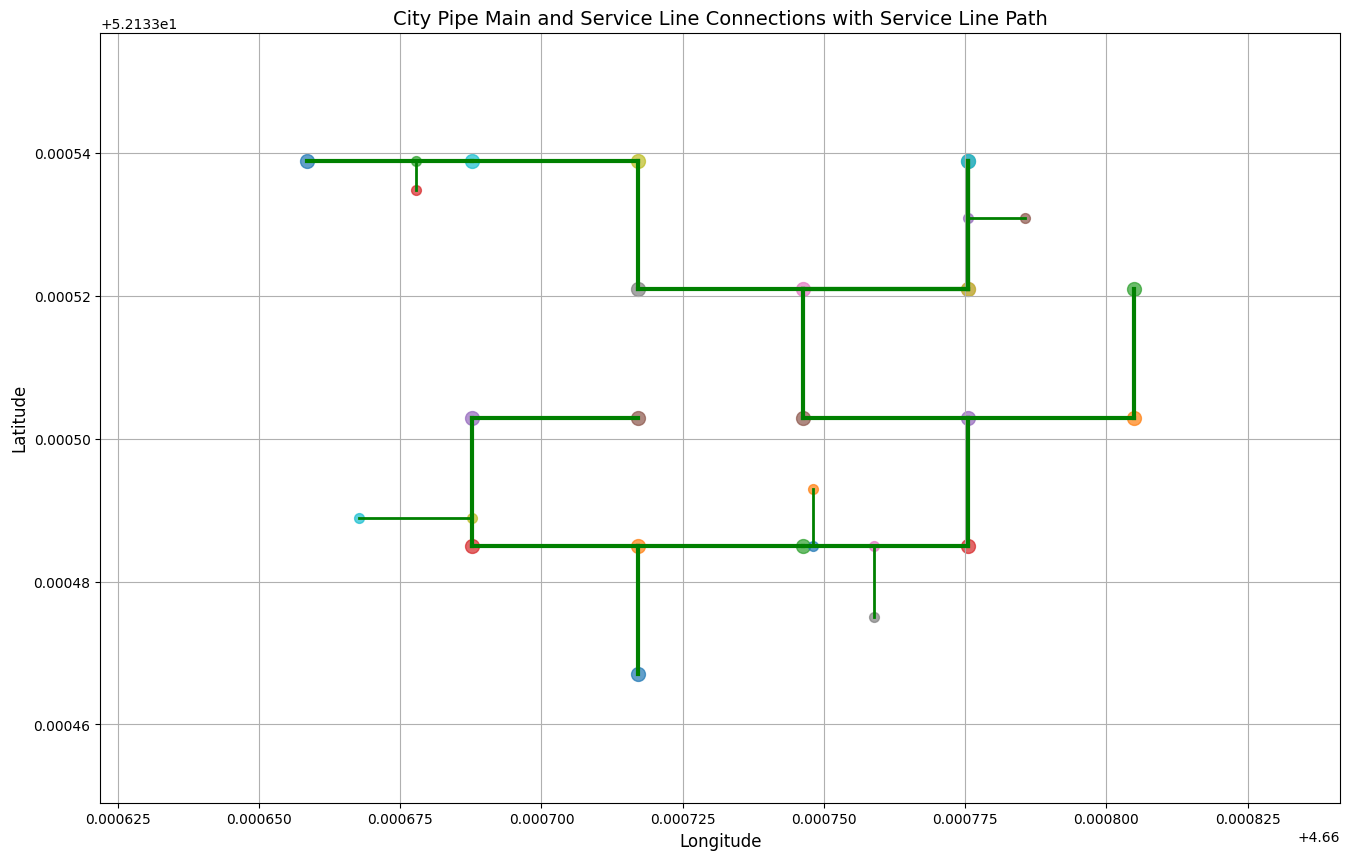

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the dataset
file_path = 'City_Pipe_Main.csv'  # Replace with the actual file path
city_pipe_main = pd.read_csv(file_path)
file_path2 = 'Service_Line_Table.csv'
service_line_table = pd.read_csv(file_path2)

# Filter rows with valid coordinates in both datasets
city_pipe_main_valid = city_pipe_main.dropna(subset=['Latitude', 'Longitude'])
service_line_table_valid = service_line_table.dropna(subset=['Latitude', 'Longitude'])

# Generate unique color mappings for directions from both datasets
all_directions = pd.concat([city_pipe_main_valid['Direction'], service_line_table_valid['Direction']]).unique()
direction_colors = {direction: plt.cm.tab20(i) for i, direction in enumerate(all_directions)}

# Process edges and positions for City Pipe Main
city_edges = []
city_positions = {}

for _, row in city_pipe_main_valid.iterrows():
    city_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    if pd.notna(row['Parent Pipe']):
        parent_row = city_pipe_main_valid[city_pipe_main_valid['SegmentID'] == row['Parent Pipe']]
        if not parent_row.empty:
            parent_lat, parent_lon = parent_row.iloc[0]['Latitude'], parent_row.iloc[0]['Longitude']
            color = direction_colors.get(row['Direction'], 'black')
            city_edges.append(((parent_lon, parent_lat), (row['Longitude'], row['Latitude']), color))

# Process edges and positions for Service Line Table
service_edges = []
service_positions = {}

for _, row in service_line_table_valid.iterrows():
    service_positions[row['SegmentID']] = (row['Longitude'], row['Latitude'])
    # Assume connection through ConnectionID; treat it similar to Parent Pipe
    if pd.notna(row['ConnectionID']):
        connection_row = service_line_table_valid[service_line_table_valid['SegmentID'] == row['ConnectionID']]
        if not connection_row.empty:
            connection_lat, connection_lon = connection_row.iloc[0]['Latitude'], connection_row.iloc[0]['Longitude']
            color = direction_colors.get(row['Direction'], 'gray')  # Default to gray if no direction color found
            service_edges.append(((connection_lon, connection_lat), (row['Longitude'], row['Latitude']), color))

# Calculate the center and zoom based on the combined data
combined_latitudes = pd.concat([city_pipe_main_valid['Latitude'], service_line_table_valid['Latitude']])
combined_longitudes = pd.concat([city_pipe_main_valid['Longitude'], service_line_table_valid['Longitude']])

center_lon = (combined_longitudes.max() + combined_longitudes.min()) / 2
center_lat = (combined_latitudes.max() + combined_latitudes.min()) / 2
lon_range = combined_longitudes.max() - combined_longitudes.min()
lat_range = combined_latitudes.max() - combined_latitudes.min()

# Adjust zoom factor
zoom_factor = 1.5

# Plot the combined visualization
service_coords = service_line_table_valid[['Latitude', 'Longitude']].dropna()

# Sort the service line points by Longitude (or Latitude for a different ordering)
service_coords_sorted = service_coords.sort_values(by='Longitude')

# Extract sorted coordinates for plotting
service_x = service_coords_sorted['Longitude'].values
service_y = service_coords_sorted['Latitude'].values

# Plot the combined visualization with the additional service line connection
plt.figure(figsize=(16, 10))

color = 'green'

# PER SEGMENT:
# switch corrosionLevel(){
# case INT: CorrosionRate:
#     color = 'green'
# case INT: CorrosionRate BETWEEN 33% & 66%:
#     color = 'orange'
# case INT: CorrosionRate >66%:
#     color = 'red'
# }

for _, row in service_line_table_valid.iterrows():
    if pd.notna(row['ParentPipe']):
        currCords = (row['Latitude'], row['Longitude'])
        
        # Find the parent row
        parentRow = service_line_table_valid.loc[service_line_table_valid['SegmentID'] == row['ParentPipe']]
        
        if not parentRow.empty:
            parentCords = (parentRow.iloc[0]['Latitude'], parentRow.iloc[0]['Longitude'])
            
            print(f"Current: {currCords}, Parent: {parentCords}")
            plt.plot(
                [currCords[1], parentCords[1]],
                [currCords[0], parentCords[0]],
                color=color, linewidth=2, linestyle='-', label='Service Line Connection'
            )

# Plot edges for City Pipe Main with thicker lines
for edge in city_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=color, linewidth=3, label='City Pipe Main Edge')

# Plot edges for Service Line Table with thinner lines
for edge in service_edges:
    x_coords = [edge[0][0], edge[1][0]]
    y_coords = [edge[0][1], edge[1][1]]
    plt.plot(x_coords, y_coords, color=color, linestyle='--', linewidth=1.5, label='Service Line Edge')

# Plot nodes for City Pipe Main
for node, (lon, lat) in city_positions.items():
    plt.scatter(lon, lat, s=100, alpha=0.7, label='City Pipe Main Node')

# Plot nodes for Service Line Table
for node, (lon, lat) in service_positions.items():
    plt.scatter(lon, lat, s=50, alpha=0.7, label='Service Line Node')

# Add title, labels, and legend
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.title("City Pipe Main and Service Line Connections with Service Line Path", fontsize=14)

# Adjust axes to zoom and center on the data
plt.xlim(center_lon - (lon_range / 2 * zoom_factor), center_lon + (lon_range / 2 * zoom_factor))
plt.ylim(center_lat - (lat_range / 2 * zoom_factor), center_lat + (lat_range / 2 * zoom_factor))

plt.grid(True)
plt.show()